In [8]:
import sys
sys.path.append('../')
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".20"
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('../flowrec/utils/ppt.mplstyle')
plt.style.use('../flowrec/utils/a4.mplstyle')
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
import h5py 
import yaml

import flowrec.utils.simulation as project
from flowrec.data import DataMetadata
from flowrec.physics_and_derivatives import momentum_residual_field, div_field
from flowrec.losses import divergence
from flowrec.utils.py_helper import slice_from_tuple
data_dir = Path("../local_data/re100")
dt = 0.125

In [9]:
# (ux,uy,pp) = project.read_data(data_dir,idx_body=132)
(ux,uy,pp) = project.read_data_2dtriangle(data_dir,idx_body=0)
# take base measurement
pb = project.take_measurement_base(pp, ly=[1.5,2.5] ,centrex=0, domain_y=4)

In [10]:
print(pb.shape,ux.shape)

(800, 31) (800, 513, 129)


## Residual

In [11]:
datainfo = DataMetadata(
    re=100,
    discretisation=[0.125, 12/512, 4/128],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()
(u1,u2,pressure) = project.read_data_2dtriangle(data_dir,idx_body=132)
loss_mom = np.mean(
    momentum_residual_field(
        u_p=np.stack((u1[:600,...,np.newaxis],u2[:600,...,np.newaxis],pressure[:600,...,np.newaxis]),axis=-1),
        datainfo=datainfo
    )**2
)*2
loss_div = divergence(
    u=np.stack((u1[:600,...,np.newaxis],u2[:600,...,np.newaxis]),axis=-1),
    datainfo=datainfo
)
lp = loss_mom+loss_div
print(f'The losses of true data - physics {lp}, momentum {loss_mom}, divergence {loss_div}.')

The losses of true data - physics 0.028566904366016388, momentum 0.028563134372234344, divergence 3.7701504425058374e-06.


## Plot data

In [12]:

def multicolor_axis_label(ax,list_of_strings,list_of_colors,bbox_to_anchor,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc='center', child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=bbox_to_anchor,
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc='center', child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=bbox_to_anchor, 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)

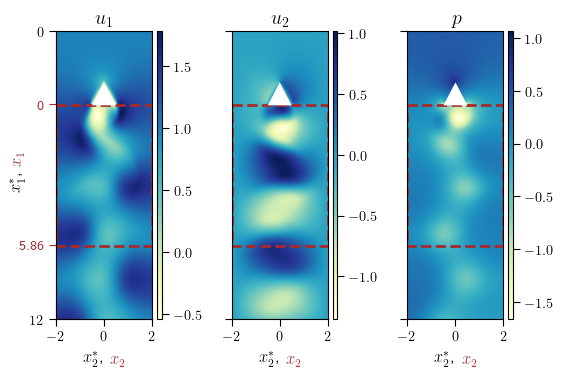

In [41]:
plt_t = 20
c = 'brown'
fig = plt.figure(figsize=(7,4))
# fig.suptitle('Data at t=20')
grid = ImageGrid(fig,111,nrows_ncols=(1,3),cbar_mode='each',axes_pad=0.7,cbar_pad=(0.05),share_all=True)
ax = grid.axes_all
cax = grid.cbar_axes
# ax[0].set(xlabel='$x^*_2$',ylabel='$x^*_1$')
im0 = ax[0].imshow(ux[plt_t,...],extent=[-2,2,12,0])#
cax[0].colorbar(im0)
ax[0].set_title('$u_1$')
im1 = ax[1].imshow(uy[plt_t,...],extent=[-2,2,12,0])#
cax[1].colorbar(im1)
ax[1].set_title('$u_2$')
im2 = ax[2].imshow(pp[plt_t,...],extent=[-2,2,12,0])#
cax[2].colorbar(im2)
ax[2].set_title('$p$')

for i in range(3):


    domain = matplotlib.patches.Rectangle((-2,3.09),4,5.86,linewidth=2,edgecolor=c,facecolor='none',linestyle='--')
    ax[i].add_patch(domain)
    body = matplotlib.patches.Polygon([[-0.5,3.09],[0.5,3.09],[0,3-(0.5*3**0.5)]],facecolor='white',edgecolor='none')
    ax[i].add_patch(body)


axx = ax[0].secondary_xaxis('bottom')
axx.set_xticklabels([])
axx.set_color('dimgrey')

def xs_to_x(xs):
    return xs - 3
def x_to_xs(x):
    return x + 3

axy = ax[0].secondary_yaxis('left',functions=(xs_to_x,x_to_xs))
axy.set_color(c)
axy.set_yticks([0.05,5.9])
axy.set_yticklabels([0,5.86])

ax[0].set_yticks([0,12])
ax[0].set_xticks([-2,0,2])

multicolor_axis_label(ax[0],['$x^*_2$,','$x_2$'],['k',c],bbox_to_anchor=(0.5,-0.15),axis='x')
multicolor_axis_label(ax[1],['$x^*_2$,','$x_2$'],['k',c],bbox_to_anchor=(0.5,-0.15),axis='x')
multicolor_axis_label(ax[2],['$x^*_2$,','$x_2$'],['k',c],bbox_to_anchor=(0.5,-0.15),axis='x')
multicolor_axis_label(ax[0],['$x^*_1$,','$x_1$'],[c,'k'],bbox_to_anchor=(-0.4,0.5),axis='y')

# plt.savefig('../figures_for_paper/figs/data_domain_2axes',bbox_inches='tight')
plt.show()

In [8]:
probe_location = (150-132,60)
probe_ux = ux[:,probe_location[0],probe_location[1]]
probe_uy = uy[:,probe_location[0],probe_location[1]]
probe_p = pb[:,probe_location[1]-49]

freq = np.fft.fftfreq(len(probe_ux),d=dt)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux))/len(probe_ux)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy))/len(probe_uy)
f_p = np.fft.fft(probe_p-np.mean(probe_p))/len(probe_p)

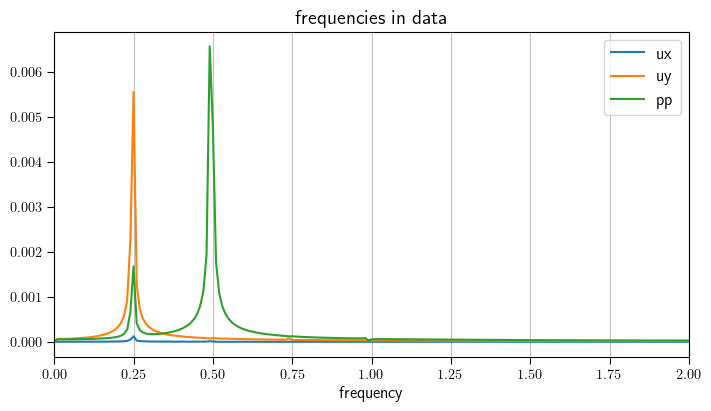

highest peak at  -0.24  Hz.


In [9]:
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_p)[:int(len(freq)/2)],label ='pp')
plt.title('frequencies in data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()
idx_sort = np.argsort(f_uy)
high_freq = freq[idx_sort][-1]
print("highest peak at ", high_freq, " Hz.")

In [10]:
amp = np.abs(f_uy[idx_sort][-1])
phase = np.angle(f_uy[idx_sort][-1])

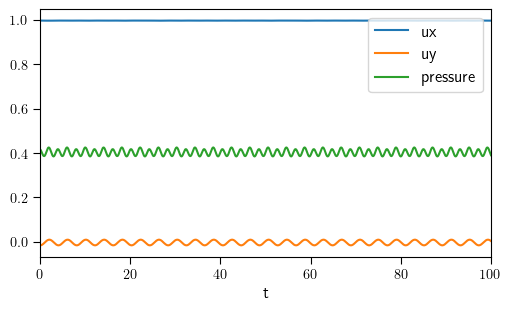

In [11]:
t = np.linspace(0,probe_ux.shape[0]*dt,probe_ux.shape[0])
plt.figure(figsize=(5,3))
# plt.title("$Re=100$")
plt.plot(t,probe_ux,label='ux')
plt.plot(t,probe_uy,label='uy')
plt.plot(t,probe_p,label='pressure')
# plt.plot(t,2*amp*np.cos(high_freq*2*np.pi*t+phase),label='main fft freq')
plt.legend(loc='upper right')
plt.xlim([0,100])
plt.xlabel("t")
plt.show()

# Uz

In [10]:
if Path(data_dir,"uz.h5").exists():
    with h5py.File(Path(data_dir,"uz.h5"),'r') as hf:
        uz = np.array(hf.get('uz'))

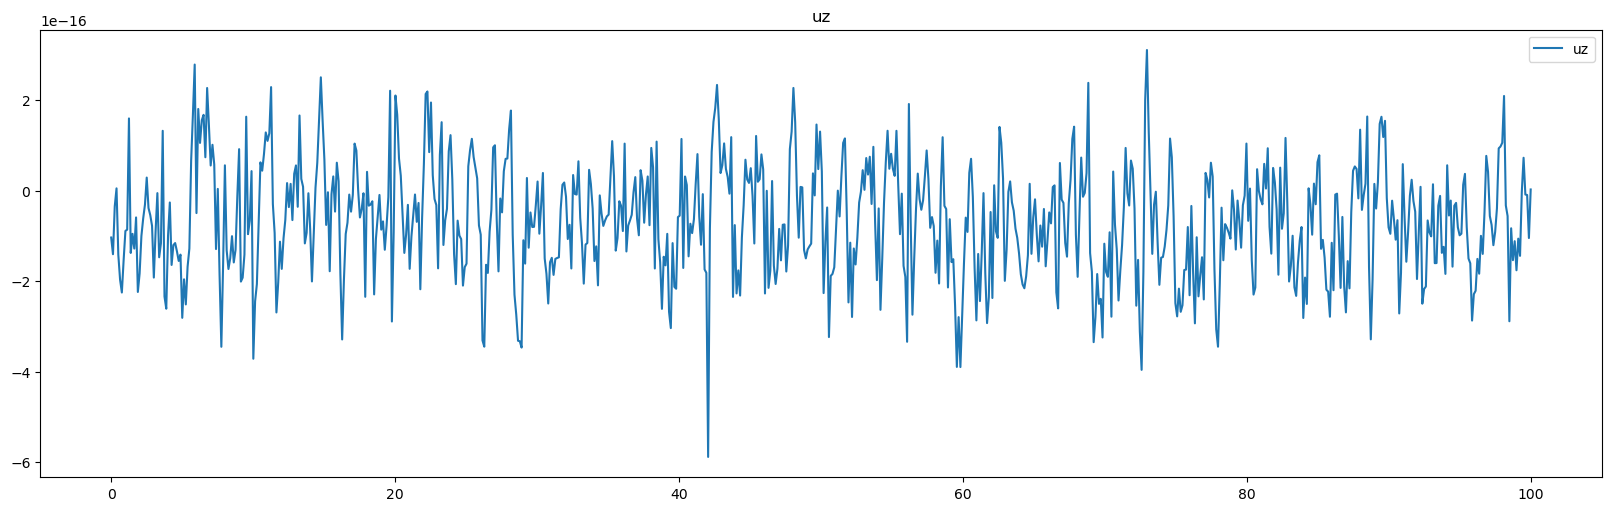

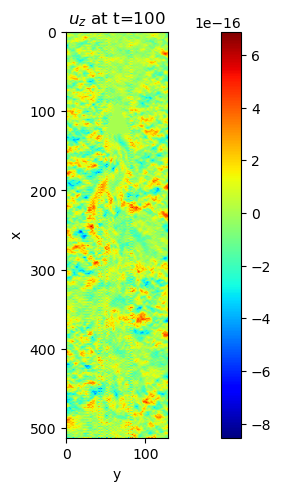

In [11]:
t = np.linspace(0,uz.shape[0]*dt,uz.shape[0])
plt.figure(figsize=(16,5))
plt.plot(t,uz[:,150,60],label='uz')
plt.legend()
plt.title('uz')

plt.figure()
plt.title('$u_z$ at t=100')
plt.imshow(uz[0,:,:])
plt.colorbar()
plt.xlabel('y')
plt.ylabel('x')

plt.show()

# Vorticity

In [12]:
with h5py.File(Path(data_dir,'vort.h5'),'r') as hf:
    vort = np.array(hf.get('vort'))
with h5py.File(Path(data_dir,'critq.h5'),'r') as hf:
    critq = np.array(hf.get('critq'))
vort.shape

(800, 513, 129)

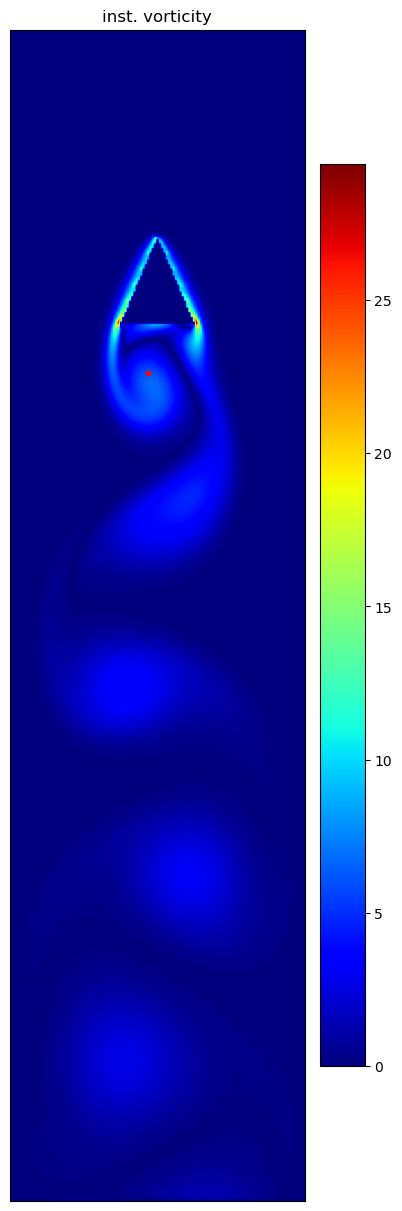

In [13]:
plt.figure(figsize=(4,12))
plt.title('inst. vorticity')
plt.imshow(vort[200,...],'jet')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.scatter(60,150,s=10,c='r')
plt.show()

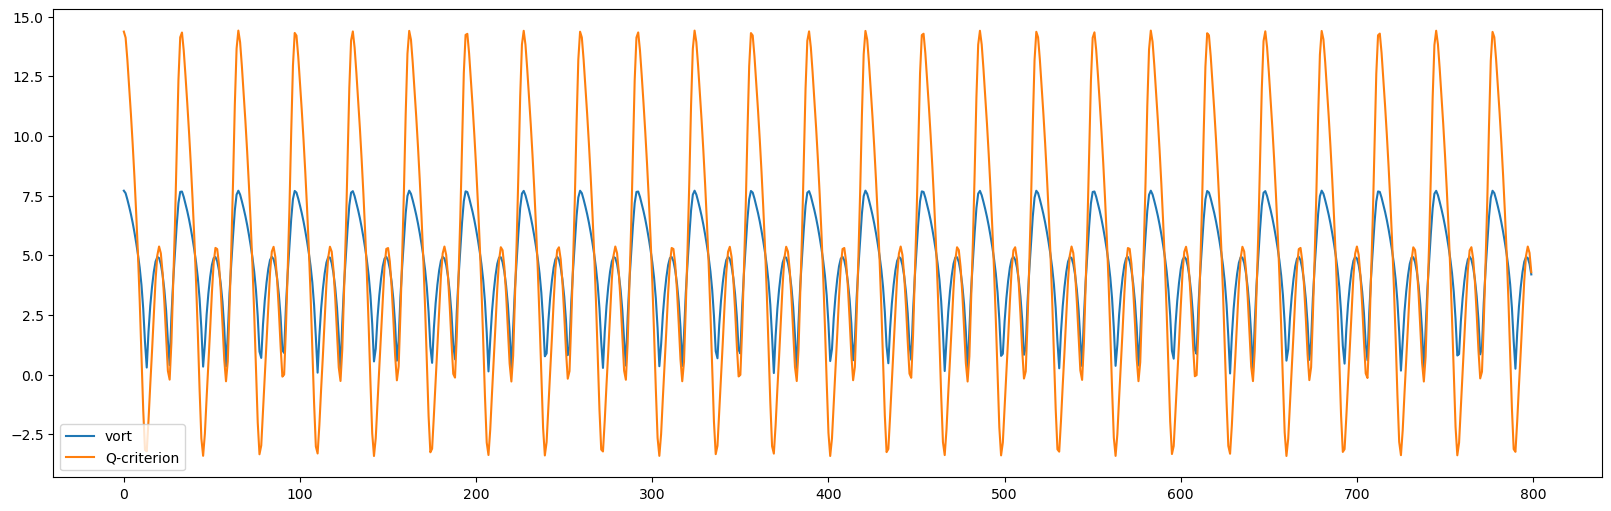

In [14]:
probe_vort = vort[:,150,60]
probe_q = critq[:,150,60]
plt.figure(figsize=(16,5))
plt.plot(probe_vort,label='vort')
plt.plot(probe_q,label='Q-criterion')
plt.legend()
plt.show()


# POD

In [14]:
triangle_base_coords = [49,80]
(ux_short,uy_short,pp_short) = project.read_data_2dtriangle(data_dir, idx_body=132)
x = np.stack([ux_short,uy_short,pp_short],axis=0)
# x = x[:778,:,:250,:]
x = x[:,:,:250,:]
x.shape

(3, 800, 250, 129)

In [15]:
from flowrec.decomposition import POD
pod = POD('float32')
q, q_mean, grid_shape = pod.prepare_data(x,t_axis=1)
modes_flat,lam,a,phi = pod.pod(q,grid_shape,method='snapshot',restore_shape=False)
modes = pod._restore_shape(modes_flat,grid_shape)
print(a.shape)
u_approx = pod.reconstruct('classic',2,modes_flat,a,q_mean=q_mean,grid_shape=grid_shape)

/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3835: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


(800, 800)


In [16]:
temp_freq = np.fft.fft(a[:,0])
maxidx = np.argmax(temp_freq)
freq[maxidx]

-0.24

mse with reconstruction is:  0.0041010263
first two mode has energy (%):  0.9573733


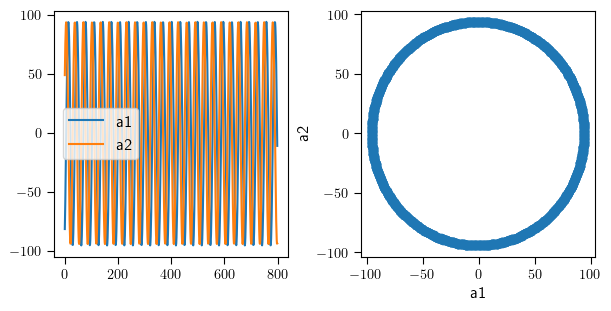

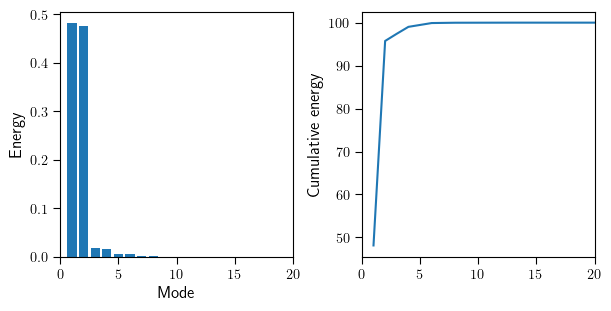

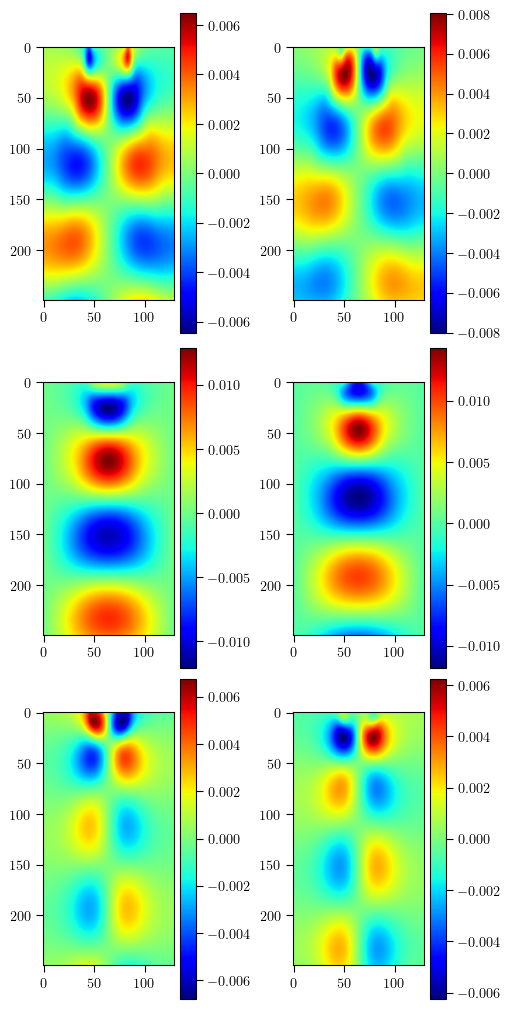

In [17]:
fig,axes = plt.subplots(1,2,figsize=(6,3))
axes[0].plot(a[:,0],label='a1')
axes[0].plot(a[:,1],label='a2')
axes[1].scatter(a[:,0],a[:,1])
axes[1].set(xlabel='a1',ylabel='a2')
axes[0].legend()


fig,ax = plt.subplots(1,2,figsize=(6,3),sharex=True)
ax[0].bar(range(1,lam.shape[-1]+1),lam/np.sum(lam))
ax[1].plot(range(1,lam.shape[-1]+1),100*np.cumsum(lam)/np.sum(lam))
ax[0].set(xlabel='Mode',ylabel='Energy %',xlim=[0,20])
ax[1].set_ylabel('Cumulative energy %')

fig1,axes1 = plt.subplots(3,2,figsize=(5,10))
for i in range(3):
    im1 = axes1[i,0].imshow(modes[i,:,:,0])
    plt.colorbar(im1)
    im2 = axes1[i,1].imshow(modes[i,:,:,1])
    plt.colorbar(im2)


_x = np.einsum('d t x y -> d x y t', x)
mse_loss = np.mean((_x-u_approx)**2)
print('mse with reconstruction is: ',mse_loss)
print('first two mode has energy (%): ',sum(lam[:2])/sum(lam))

# Raw data
computation domain only

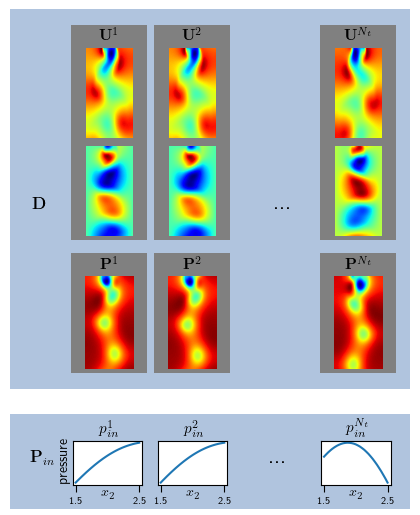

In [18]:
fig = plt.figure(figsize=(4,5))
# fig.tight_layout()
subfigs = fig.subfigures(2,1,height_ratios=[0.8,0.2],hspace=0.1,facecolor='lightsteelblue')
ssfig1 = subfigs[0].subfigures(4,6,height_ratios=[0.01,0.68,0.38,0.01],width_ratios=[0.15,0.21,0.21,0.21,0.21,0.02],hspace=0.1,wspace=0.1,facecolor='lightsteelblue')

axin = subfigs[1].subplots(1,6,width_ratios=[0.14,0.21,0.21,0.21,0.21,0.01])

axin[0].axis('off')
axin[-1].axis('off')
axin[3].axis('off')

_time = [0,1,-1]
_fig = [1,2,4]
_title = ['1','2','{N_t}']
_base = np.linspace(1.5,2.5,31)

# for i in range(6):
#     ssfig1[0,i].patch.set_alpha(0)
#     # ssfig1[1,i].patch.set_alpha(0)


# pressure
for t in range(3):
    
    ssfig1[1,_fig[t]].set_facecolor('grey')
    axu1 = ssfig1[1,_fig[t]].add_subplot(211)
    axu2 = ssfig1[1,_fig[t]].add_subplot(212)
    axu2.axis('off')
    axu1.axis('off')
    axu1.imshow(x[0,_time[t],...])
    axu2.imshow(x[1,_time[t],...])
    b = "$\mathbf{U}^{" + str(_title[t]) + "}$"
    axu1.set_title(b,fontsize=11)

    axp = ssfig1[2,_fig[t]].add_subplot(111)
    ssfig1[2,_fig[t]].set_facecolor('grey')
    axp.axis('off')
    axp.imshow(x[2,_time[t],...])
    d = "$\mathbf{P}^{" + str(_title[t]) + "}$"
    axp.set_title(d,fontsize=11)
    
    axin[_fig[t]].plot(_base,pb[_time[t],:])
    a = "$p_{in}^{" + str(_title[t]) + "}$"
    axin[_fig[t]].set(yticks=[])
    axin[_fig[t]].set_title(a,fontsize=11)
    axin[_fig[t]].set_xticks([1.5,2.5],[1.5,2.5],fontsize=7)
    axin[_fig[t]].set_xlabel('$x_2$',fontsize=10)
    axin[_fig[t]].xaxis.set_label_coords(0.5, -0.05)
    
subfigs[1].text(0.12,0.3,'pressure',rotation='vertical',fontsize=10)
subfigs[1].text(0.05,0.5,'$\mathbf{P}_{in}$')
subfigs[1].text(0.65,0.5,'...',fontsize=16)
ssfig1[1,0].text(0.4,0.15,'$\mathbf{D}$')
ssfig1[1,3].text(0.5,0.15,'...',fontsize=16)


# plt.savefig('../figures_for_paper/figs/data_notations',bbox_inches='tight')

plt.show()

# Locations of the sensors

### Grid

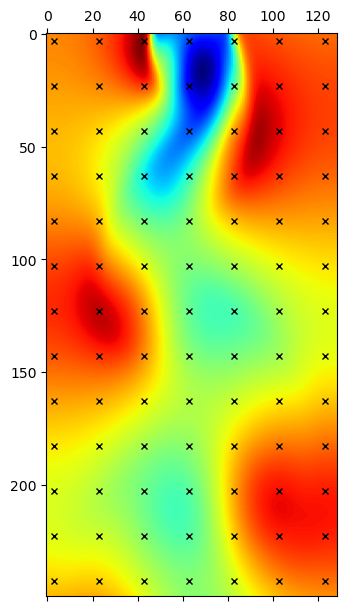

In [19]:
slice_tuple = ((3,None,20),(3,None,20))
sensor_index = (np.s_[:],) + slice_from_tuple(slice_tuple)


observed_plot = np.empty_like(ux_short[:,:250,:])
observed_plot.fill(np.nan)
observed_plot[sensor_index] = ux_short[:,:250,:][sensor_index]
plt.figure(figsize=(4,6))
plt.imshow(ux_short[0,:250,:])
plt.spy(observed_plot[0,...],color='k',marker='x',markersize=5)
plt.show()



### By hand
Pick any arbitrary points

xi [ 44  73  11  28  27  18  54  44  44 140 103   5 150 175 200 225 245 245]
yi [ 65  64  78  48  81  51  84  81  47  64  64  48  10 119  10 119  10 119]
18


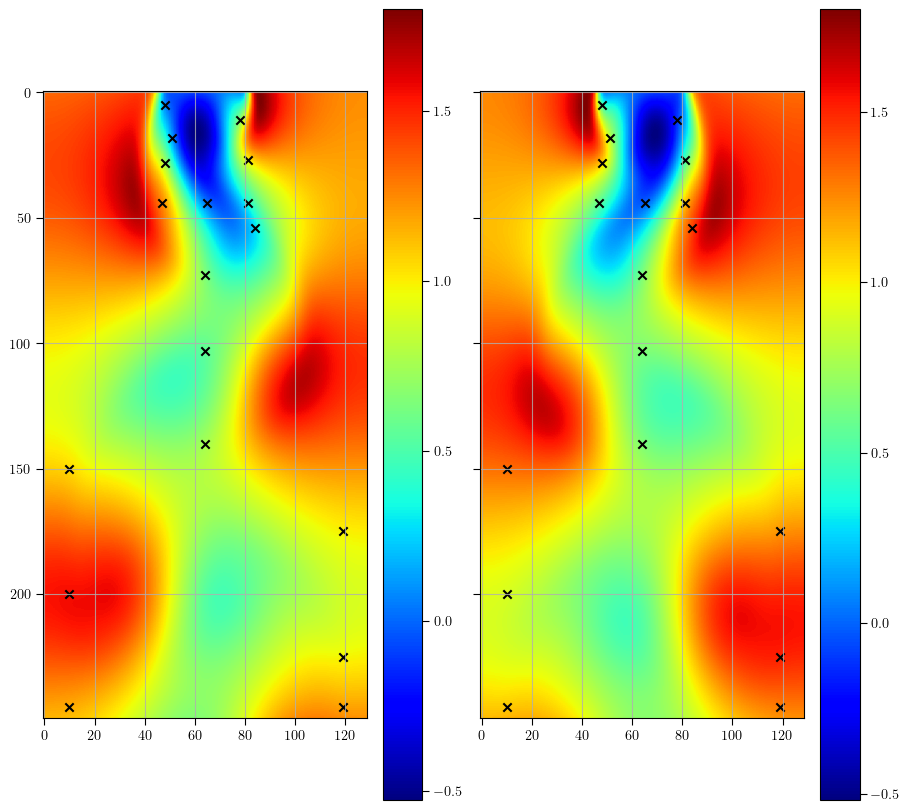

In [19]:
fig,ax = plt.subplots(1,2,figsize=(9,8),sharex=True,sharey=True)
# fig = plt.figure(figsize=(4,8))
im0 = ax[0].imshow(ux_short[500,:250,:],'jet')
plt.colorbar(im0)
ax[0].grid(True, 'both')
im1 = ax[1].imshow(ux_short[0,:250,:],'jet')
plt.colorbar(im1)
ax[1].grid(True, 'both')

# add sensors here
qr_xi = (44,73,42,69,76,69,81,70,71,70,11,28,9,27,15,28,14,18,26,12,29,54,26,52,26,28,50,26,25,25,44, 44, 23, 23, 140, 68, 40, 103, 5, 5, )
qr_yi = (65,64,62,58,65,62,65,65,66,66,78,48,78,81,77,79,79,51,49,51,77,84,78,83,51,77,84,77,77,78,81, 47, 51, 77, 64, 64, 64, 64, 80, 48,)

xi = qr_xi + (150, 175, 200, 225, 245, 245)
yi = qr_yi + ( 10, 119, 10, 119, 10, 119)

from flowrec.sensors import keep_one_point_per_cluster

idx = np.array([xi,yi]).T
new_idx = idx
new_idx = keep_one_point_per_cluster(idx,10)
print('xi',new_idx[:,0])
print('yi',new_idx[:,1])



sensors = (new_idx[:,1],new_idx[:,0])
ax[0].scatter(*sensors,marker='x',c='k')
ax[1].scatter(*sensors,marker='x',c='k')


print(new_idx.shape[0])
plt.show()

In [20]:
arr = np.random.randint(low=0,high=9,size=(3,3))
print(arr)
mask = np.array([True, True, False])
arr1 = arr[:,mask]
arr1[mask,:]

[[7 8 8]
 [7 2 0]
 [6 6 5]]


array([[7, 8],
       [7, 2]])

### max and min from POD
The the maximum and minimum of the first few POD modes, for each velocity/pressure.

In [67]:
how_many_modes = 2
nb_pairs = 1

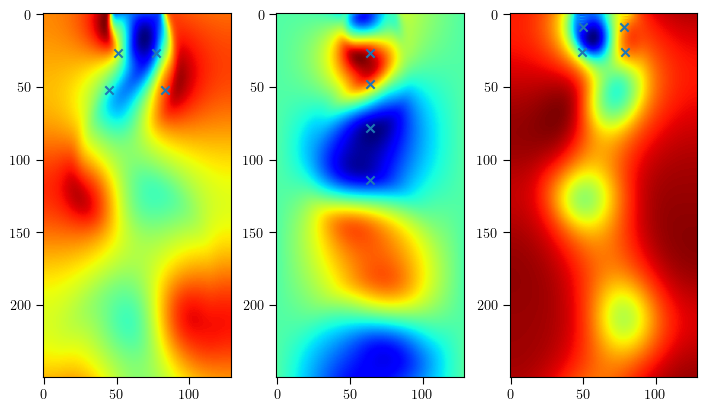

In [68]:
sx = []
sy = []
sp = []
mode_shape = modes[0,:,:,0].shape
for i in range(how_many_modes):
    sx.append(np.stack(np.unravel_index(np.argsort(modes[0,:,:,i],axis=None)[-nb_pairs:],mode_shape),axis=1))
    sy.append(np.stack(np.unravel_index(np.argsort(modes[1,:,:,i],axis=None)[-nb_pairs:],mode_shape),axis=1))
    sp.append(np.stack(np.unravel_index(np.argsort(modes[2,:,:,i],axis=None)[-nb_pairs:],mode_shape),axis=1))

    sx.append(np.stack(np.unravel_index(np.argsort(modes[0,:,:,i],axis=None)[:nb_pairs],mode_shape),axis=1))
    sy.append(np.stack(np.unravel_index(np.argsort(modes[1,:,:,i],axis=None)[:nb_pairs],mode_shape),axis=1))
    sp.append(np.stack(np.unravel_index(np.argsort(modes[2,:,:,i],axis=None)[:nb_pairs],mode_shape),axis=1))

sx = np.array(sx).reshape((how_many_modes*nb_pairs*2,-1)) # [# of sensors, coordinates]
sy = np.array(sy).reshape((how_many_modes*nb_pairs*2,-1))
sp = np.array(sp).reshape((how_many_modes*nb_pairs*2,-1))

fig,axes = plt.subplots(1,3)
axes[0].imshow(x[0,0,:,:])
axes[0].scatter(sx[:,1],sx[:,0],marker='x')
axes[1].imshow(x[1,0,:,:])
axes[1].scatter(sy[:,1],sy[:,0],marker='x')
axes[2].imshow(x[2,0,:,:])
axes[2].scatter(sp[:,1],sp[:,0],marker='x')

plt.show()

In [81]:
xi_pod = []
yi_pod = []
xi_pod.extend(sx[:,0])
xi_pod.extend(sy[:,0])
xi_pod.extend(sp[:,0])
yi_pod.extend(sx[:,1])
yi_pod.extend(sy[:,1])
yi_pod.extend(sp[:,1])
print('x coordinates: ', xi_pod)
print('y coordinates: ', yi_pod)

x coordinates:  [52, 52, 27, 27, 78, 27, 48, 114, 9, 9, 26, 26]
y coordinates:  [45, 83, 51, 77, 64, 64, 64, 64, 50, 78, 79, 49]


Pick some extra sensor points

In [82]:
modes.shape
print(np.unravel_index(np.argmax(modes[1,150:,:,1]),mode_shape))
print(np.unravel_index(np.argmin(modes[1,150:,:,1]),mode_shape))

(42, 64)
(99, 64)


In [94]:
sensors_extra = []
sensors_extra.append([160,15])
sensors_extra.append([200,97])
sensors_extra.append([220,64])
sensors_extra.append([230,34])
sensors_extra.append([187,92])
sensors_extra.append([232,115])
sensors_extra.append([10,10])
sensors_extra.append([10,115])
sensors_extra = np.array(sensors_extra)
sensors_extra.shape

xi_pod.extend(sensors_extra[:,0])
yi_pod.extend(sensors_extra[:,1])
idx_pod = np.array([xi_pod,yi_pod]).T
new_idx_pod = keep_one_point_per_cluster(idx_pod,10)
print('x coordinates: ', new_idx_pod[:,0])
print('y coordinates: ', new_idx_pod[:,1])
print(len(new_idx_pod[:,0]))

x coordinates:  [ 52  52  27  27  78  27  48 114   9   9 160 200 220 230 187 232  10  10]
y coordinates:  [ 45  83  51  77  64  64  64  64  50  78  15  97  64  34  92 115  10 115]
18


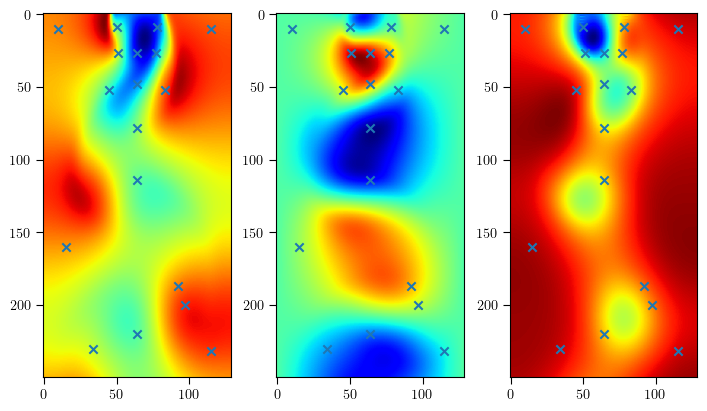

In [95]:
fig,axes = plt.subplots(1,3)
axes[0].imshow(x[0,0,:,:])
axes[0].scatter(new_idx_pod[:,1],new_idx_pod[:,0],marker='x')
axes[1].imshow(x[1,0,:,:])
axes[1].scatter(new_idx_pod[:,1],new_idx_pod[:,0],marker='x')
axes[2].imshow(x[2,0,:,:])
axes[2].scatter(new_idx_pod[:,1],new_idx_pod[:,0],marker='x')

plt.show()

# Make gif

In [ ]:
from matplotlib import animation

fps = 24
sec = 24
plt_data = np.einsum('t x y -> t y x',vort)
fig_gif = plt.figure()
im = plt.imshow(plt_data[0,:,:],vmin =-0.0, vmax=80.0, cmap='jet')
# im = plt.imshow(plt_data[0,:,:], cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title('vorticity')
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
def animation_fun(i):
    im.set_array(plt_data[i,:,:])
    return[im]

# gif = animation.FuncAnimation(fig_gif,
#                                 animation_fun,
#                                 frames=np.arange(fps*sec),
#                                 interval=1000/fps,
#                                 repeat=False)
# gif.save('data_animation.gif',fps=fps)